In [1]:
import agnprocesses.cosmology as cosmology
import agnprocesses.synchro as synchro
import agnprocesses.ic as ic
import agnprocesses.spectra as spec
import agnprocesses.ebl as ebl
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker
import subprocess  # to run prompt scripts from python
from scipy.integrate import simps
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy import interpolate
from scipy import stats
from electromagnetic_cascades import *

Hey!


# Geometry, energy range and other common parameters

In [2]:
z = 0.361  # http://linker.aanda.org/10.1051/0004-6361/201833618/54
r_blr = (0.036 * u.pc).to(u.cm)  # BLR radius
print("r_blr = {:.3e}".format(r_blr))
d_l = cosmology.luminosity_distance(z).to(u.cm)
print("d_l = {:.3e} = {:.3e}".format(d_l.to(u.cm), d_l.to(u.Mpc)))

r_blr = 1.111e+17 cm
d_l = 6.125e+27 cm = 1.985e+03 Mpc


path to photon field file (6852 strings):

In [3]:
field = "data/PKS1510-089/nph"

minimum, maximum observable energies, reference energy for spectrum laws:

In [4]:
e_min_value = 1.0e+08  # eV
e_max_value = 1.0e+12  # eV
en_ref = 1.0e+10  # eV
scale_norm = 1e-19

## Definition of log-parabolic spectrum

In [5]:
def my_spec(en, alpha, beta, norm_scaled,
            scale_norm=1):
    norm = scale_norm * norm_scaled
    return(spec.log_parabola(en, alpha, beta, en_ref=en_ref, norm=norm))

## Telescope data

In [6]:
# Data Fermi-LAT
data_fermi = np.loadtxt(
    'data/PKS1510-089/4fgl_j1512.8-0906_energy_sed_downerror_uperror_Revision1_v2.txt'
)
data_en_fermi = data_fermi[:, 0] * 1.0e+06  # MeV -> eV
data_sed_fermi = data_fermi[:, 1] * 1.0e+06  # MeV -> eV
data_down_fermi = data_fermi[:, 2] * 1.0e+06  # MeV -> eV
data_up_fermi = data_fermi[:, 3] * 1.0e+06  # MeV -> eV
NUMBER_OF_FERMI_DOTS = data_en_fermi.shape[0]
yerr_stat_fermi = [data_down_fermi, data_up_fermi]
# Data magic
data_magic = np.loadtxt(
    'data/PKS1510-089/4FGL J1512.8-0906_MAGIC_energy_SED_downerror_uperror.txt')
data_en_magic = data_magic[:, 0] * 1.0e+06  # MeV -> eV
data_sed_magic = data_magic[:, 1] * 1.0e+06  # MeV -> eV
data_down_magic = data_magic[:, 2] * 1.0e+06  # MeV -> eV
data_up_magic = data_magic[:, 3] * 1.0e+06  # MeV -> eV
yerr_stat_magic = [data_down_magic, data_up_magic]
#########################################################################
data_syst_magic_up = np.loadtxt(
    "data/PKS1510-089/MAGIC_systematics_up.txt" # boundary, not difference!
)
syst_magic_en_up = data_syst_magic_up[:, 0] * 1.0e+09 # GeV -> eV
syst_magic_sed_up = data_syst_magic_up[:, 1] * 1.0e+12  # TeV -> eV
data_syst_magic_down = np.loadtxt(
    "data/PKS1510-089/MAGIC_systematics_down.txt" # boundary, not difference!
)
syst_magic_en_down = data_syst_magic_down[:, 0] * 1.0e+09  # GeV -> eV
syst_magic_sed_down = data_syst_magic_down[:, 1] * 1.0e+12  # TeV -> eV
syst_magic_en_common = np.sort(np.concatenate(
    [syst_magic_en_down, syst_magic_en_up]
))

In [7]:
x_data = [np.concatenate([data_en_fermi, data_en_magic], axis=0), # central dots
          np.concatenate([data_en_fermi, syst_magic_en_down], axis=0), # down dots
          np.concatenate([data_en_fermi, syst_magic_en_up], axis=0)] # up dots
y_data = [np.concatenate([data_sed_fermi, data_sed_magic], axis=0), # central dots
          np.concatenate([data_sed_fermi, syst_magic_sed_down], axis=0), # down dots
          np.concatenate([data_sed_fermi, syst_magic_sed_up], axis=0)] # up dots
# statistical MAGIC errors are the same!
yerr_stat = [
    np.concatenate([yerr_stat_fermi[0],
                    yerr_stat_magic[0]],
                   axis=0),
    np.concatenate([yerr_stat_fermi[1],
                    yerr_stat_magic[1]],
                   axis=0)
]
en_observable = np.logspace(np.log10(e_min_value),
                            np.log10(e_max_value),
                            100)

# Acciari et al. (2018) Fermi-LAT SED

In [8]:
Acciari = np.loadtxt("data/PKS1510-089/Acciari18a_Fermi-LAT_SED_center.txt")
Acciari_energy = Acciari[:, 0] * 1.0e+09 # GeV -> eV
Acciari_SED = Acciari[:, 1] * 1.0e+12 # TeV cm^{-2} s^{-1} -> eV cm^{-2} s^{-1}

Acciari_up = np.loadtxt("data/PKS1510-089/Acciari18a_Fermi-LAT_SED_up.txt")[:, 1]
Acciari_down = np.loadtxt("data/PKS1510-089/Acciari18a_Fermi-LAT_SED_down.txt")[:, 1]

Acciari_yerr = [Acciari_SED - Acciari_down, Acciari_up - Acciari_SED]

# Internal absorption-only model (model 0)

## Model 0 SED function

In [9]:
def model0_SED(en_observable, alpha, beta, norm_scaled,
               redshift=z,
               scale_norm=scale_norm
):
    en_source = en_observable * (1.0 + redshift)
    SED = en_source**2 * my_spec(en_source, alpha, beta, norm_scaled, scale_norm=scale_norm)
    SED = SED * np.exp(-ebl.tau_gilmore(en_observable * u.eV, z))
    SED = SED / (1.0 + redshift)
    return SED

## Function to fit the data with the model 0 SED function

In [10]:
def residual_func(pars,
                  x_data=x_data,
                  y_data=y_data,
                  sigma=True,
                  yerr_stat=yerr_stat,
                  f=model0_SED):
    model = f(x_data, *pars)
    res = np.zeros(x_data.shape)
    if sigma:
        for i, value in enumerate(model):
            if (value - y_data[i]) < 0: # using down errors
                err = yerr_stat[0][i]
            else: # using up errors
                err = yerr_stat[1][i]
            res[i] = (value - y_data[i]) / err
    else:
        res = (model - y_data)
    return res

## Fitting to the data 

In [11]:
x0 = [2.7, 0.037, 1.3]
bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])

In [12]:
optimized = []
for i in range(0, len(x_data)):
    print(i)
    optimized.append(
        least_squares(
            residual_func,
            x0,
            jac='3-point',
            bounds=bounds,
            method='trf', 
            ftol=1e-12,
            xtol=1e-12,
            gtol=1e-12,
            x_scale='jac', # 1.0
            loss='linear',
            f_scale=1.0,
            diff_step=None,
            tr_solver=None,
            tr_options={},
            jac_sparsity=None,
            max_nfev=None,
            verbose=2,
            args=(),
            kwargs={
                'x_data': x_data[i],
                'y_data': y_data[i],
                'sigma': True,
                'yerr_stat': yerr_stat,
                'f': model0_SED
            }
        )
    )
    print(optimized[i]['message'])
    print("Success: {}".format(optimized[i]['success']))
    print("Residual chi squared: ", 2.0 * optimized[i]['cost'])
    print("Best-fit parameters: ", optimized[i]['x'])
    print("-----------------------------------------------------------------------------")

0
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.3346e+03                                    2.51e+05    
       1              2         1.1228e+02      3.22e+03       9.60e-02       2.64e+04    
       2              3         4.2355e+01      6.99e+01       3.09e-02       6.73e+02    
       3              4         4.2289e+01      6.61e-02       5.84e-03       5.99e+00    
       4              5         4.2288e+01      9.36e-04       1.34e-03       4.29e-01    
       5              6         4.2288e+01      6.85e-05       3.71e-04       1.19e-01    
       6              7         4.2288e+01      5.05e-06       1.00e-04       3.28e-02    
       7              8         4.2288e+01      3.73e-07       2.73e-05       8.96e-03    
       8              9         4.2288e+01      2.75e-08       7.42e-06       2.44e-03    
       9             10         4.2288e+01      2.03e-09       2.02e-06       6.63e-04  

In [13]:
popt_null_model= []
for i in range(0, len(optimized)):
    popt_null_model.append(optimized[i]['x'])
popt_null_model

[array([2.59049916, 0.03703567, 1.28762158]),
 array([2.60844019, 0.04039082, 1.26129133]),
 array([2.5776934 , 0.03462084, 1.30643016])]

In [14]:
# ndof_null_model = x_data[0].shape[0] - popt_null_model[0].shape[0] - 1
ndof_null_model = x_data[0].shape[0] - popt_null_model[0].shape[0]
ndof_null_model

15

In [15]:
chisq_null_model = []
for i in range(0, len(optimized)):
    chisq_null_model.append(
        np.sum(
            (residual_func(
                popt_null_model[i],
                x_data=x_data[i],
                y_data=y_data[i],
                sigma=True,
                yerr_stat=yerr_stat,
                f=model0_SED))**2
        )
    )
    print("chi squared / n.d.o.f. = ", chisq_null_model[i] / ndof_null_model)
chisq_null_model

chi squared / n.d.o.f. =  5.638398524719418
chi squared / n.d.o.f. =  3.0050008943802298
chi squared / n.d.o.f. =  9.355899506513547


[84.57597787079126, 45.075013415703445, 140.3384925977032]

In [16]:
p_value_null_model = []
significance_null_model = []
for i in range(0, len(optimized)):
    p_value_null_model.append(
        stats.chi2.sf(chisq_null_model[i],
                      df=ndof_null_model)
    )
    significance_null_model.append(
        stats.norm.ppf(1.0 - p_value_null_model[i] / 2.0)
    )
print(p_value_null_model)
print(significance_null_model)

[1.0075113647908118e-11, 7.45131811727335e-05, 1.973554503432055e-22]
[6.805426197126169, 3.961394894007967, inf]


In [17]:
sed_null_model = []
for i in range(0, len(optimized)):
    sed_null_model.append(model0_SED(en_observable, *(popt_null_model[i])))

## Primary spectrum in the source frame before the EBL absorption

In [18]:
# en_source_null_model = en_observable * (1.0 + z)
# sed_source_null_model = []
# for i in range(0, len(optimized)):
#     sed_source_null_model.append(
#         (my_spec(en_source_null_model,
#                  *popt_null_model[i][:-1],
#                  scale_norm=scale_norm
#                 ) *
#          en_source_null_model**2)
#     )

## Plotting results

In [19]:
fontsize_ticks = 22
fontsize_legend = 21
fontsize_axis_title = 25
linewidth = 4
markersize = 12

In [20]:
magic_colors = ['tab:red', 'tab:purple', 'tab:brown']

In [21]:
e_low = np.logspace(8, 9, 1000)
sed_null_low = model0_SED(e_low, *(popt_null_model[0]))
photons_in_low = simps(sed_null_low / e_low**2, e_low)
photons_in_low

4.375753200513805e-07

In [22]:
e_high = np.logspace(9, 11.5, 1000)
sed_null_high = model0_SED(e_high, *(popt_null_model[0]))
photons_in_high = simps(sed_null_high / e_high**2, e_high)
photons_in_high

1.7773751959083972e-08

In [23]:
fig, ax1 = plt.subplots(1, 1,
                        figsize=(16, 12),
                        sharex=False,
                        sharey=False,
                        dpi=600)

filt_null_model = (en_observable < 5e+11)
ax1.plot(
    en_observable[filt_null_model], sed_null_model[i][filt_null_model],
    marker=None,
    linestyle='-',
    linewidth=linewidth,
    color="black",
    label='Model 0, Earth frame'
)

ax1.errorbar(data_en_fermi, data_sed_fermi,
             yerr=yerr_stat_fermi, xerr=None, fmt='o', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, color='b', zorder=100.0,
             label='Fermi-LAT data')

ax1.errorbar(Acciari_energy, Acciari_SED,
             yerr=Acciari_yerr, xerr=None, fmt='d', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, color='grey', zorder=100.0,
             label='Fermi-LAT data (MAGIC collaboration et al. 2018)')

ax1.errorbar(data_en_magic, data_sed_magic,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             label='MAGIC data (MAGIC collaboration et al. 2018)',
             color=magic_colors[0])

ax1.errorbar(syst_magic_en_down, syst_magic_sed_down,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             fillstyle='none',
             color=magic_colors[1])

ax1.errorbar(syst_magic_en_up, syst_magic_sed_up,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             fillstyle='none',
             color=magic_colors[-1])

ax1.set_ylabel('SED ' + r'[eV cm$^{-2}$s$^{-1}$]', fontsize=fontsize_axis_title)
ax1.set_xlabel('Energy [eV]', fontsize=fontsize_axis_title)
ax1.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1.0e+08, 1.0e+12)
ax1.set_ylim(4.0e-01, 100.0)
# ax1.set_ylim(10, 100.0)
ax1.grid()
ax1.legend(fontsize=fontsize_legend, loc='lower left')

plt.tight_layout()
plt.show()
# fig.savefig('test_figures/PKS1510-089/journal/model0_revision2_v1.pdf')
# fig.savefig('test_figures/PKS1510-089/journal/model0_revision2_v1.png')

# 2-component model

## Check quasi-universality of gamma rays spectra from pp-interactions

In [24]:
F_gamma_table16 = np.loadtxt("data/Processes-Timur/ProtonProtonGamma-1e16")
F_gamma_table14 = np.loadtxt("data/Processes-Timur/ProtonProtonGamma-1e14")

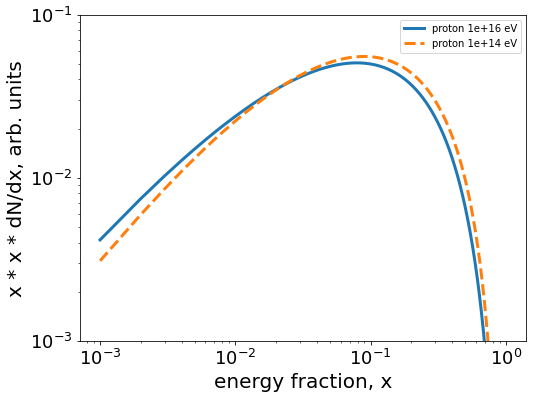

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(
    F_gamma_table16[:, 0], F_gamma_table16[:, 1],
    marker=None,
    linestyle='-',
    linewidth=3,
    label='proton 1e+16 eV'
)

plt.plot(
    F_gamma_table14[:, 0], F_gamma_table14[:, 1],
    marker=None,
    linestyle='--',
    linewidth=3,
    label='proton 1e+14 eV'
)

plt.xlabel('energy fraction, ' + 'x', fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel('x * x * dN/dx, ' + 'arb. units', fontsize=20)
plt.yticks(fontsize=18)
ax.set_xscale('log')
ax.set_ylim(1.0e-03, 1.0e-01)
ax.set_yscale('log')
plt.legend(fontsize=10)
plt.show()
# fig.savefig('test_figures/PKS1510-089/journal/check_scaling.pdf')

## Functions for gamma-ray spectrum calculations (from pp-interactions)

In [26]:
def sigma_pp_inelastic_cross_section(e):
    """
    proton-proton cross section:
    see http://dx.doi.org/10.1103/PhysRevD.74.034018
    (Kelner et al. (2006), eq. (79))
    """
    e = e.to(u.TeV)
    L = np.log(e.value)
    e_thr = (1.22e-03 * u.TeV).to(u.eV)
    return ((34.3 + 1.88 * L + 0.25 * L**2) *
            (1.0 - (e_thr / e)**4)**2 * 1.0e-27 * u.cm**2)

# F_gamma_table = np.loadtxt("data/Processes-Timur/ProtonProtonGamma-1e16")
F_gamma_table = np.loadtxt("data/Processes-Timur/ProtonProtonGamma-1e14")
logx1 = np.log10(F_gamma_table[:, 0])
logy1 = np.log10(F_gamma_table[:, 1])
log_F_gamma_interpol = interpolate.interp1d(logx1, logy1,
                                            kind='linear',
                                            bounds_error=False,
                                            fill_value='extrapolate')

def F_gamma_interpol_aux(x):
    xl = np.log10(x)
    return ((10.0**log_F_gamma_interpol(xl)) / x**2)

def F_gamma_approx(E_gamma, E_proton):
    """
    Returns the spectrum of gamma rays from proton-proton interactions
    in frame of the scaling (1 / E_proton) approximation.
    """
    x = E_gamma / E_proton
    return (F_gamma_interpol_aux(x) / E_proton)

In [27]:
e_proton_test = 10**13.50
e_gamma = np.logspace(11, 13.33)
x_gamma = e_gamma / e_proton_test
f_gamma_test = F_gamma_approx(e_gamma, e_proton_test) * e_proton_test * x_gamma**2

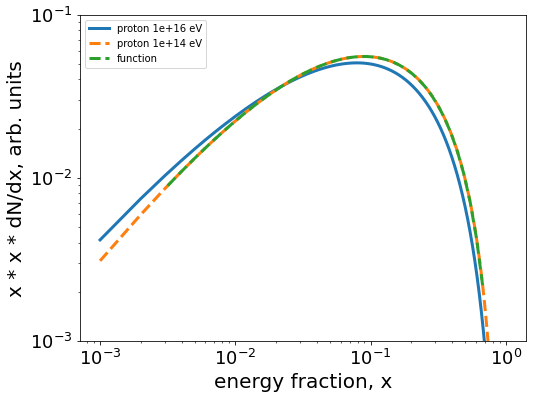

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(
    F_gamma_table16[:, 0], F_gamma_table16[:, 1],
    marker=None,
    linestyle='-',
    linewidth=3,
    label='proton 1e+16 eV'
)

plt.plot(
    F_gamma_table14[:, 0], F_gamma_table14[:, 1],
    marker=None,
    linestyle='--',
    linewidth=3,
    label='proton 1e+14 eV'
)

plt.plot(
    x_gamma, f_gamma_test,
    marker=None,
    linestyle='--',
    linewidth=3,
    label='function'
)

plt.xlabel('energy fraction, ' + 'x', fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel('x * x * dN/dx, ' + 'arb. units', fontsize=20)
plt.yticks(fontsize=18)
ax.set_xscale('log')
ax.set_ylim(1.0e-03, 1.0e-01)
ax.set_yscale('log')
plt.legend(fontsize=10)
plt.show()
# fig.savefig('test_figures/PKS1510-089/journal/check_scaling.pdf')

In [29]:
proton_normalization = 2e-17 * u.eV**(-1) * u.s**(-1) * u.cm**(-2)
proton_spectral_index = 1.8

In [30]:
# proton_energy = np.logspace(13.50, 14.77, 100) * u.eV
proton_energy = np.logspace(13.0, 15.0, 100) * u.eV
proton_spectrum = spec.power_law(
    proton_energy,
    proton_spectral_index,
    norm=proton_normalization,
    en_ref=en_ref * u.eV)
proton_column_density = 1.0e+23 * u.cm**(-2)
proton_tau = (proton_column_density *
              sigma_pp_inelastic_cross_section(proton_energy))
print("proton tau = ", proton_tau)
proton_spectrum_interacted = proton_spectrum * (1.0 - np.exp(-proton_tau))

proton tau =  [0.00399543 0.00400959 0.00402385 0.00403822 0.0040527  0.00406729
 0.00408198 0.00409679 0.0041117  0.00412672 0.00414185 0.00415709
 0.00417243 0.00418788 0.00420344 0.00421911 0.00423489 0.00425078
 0.00426677 0.00428287 0.00429908 0.0043154  0.00433183 0.00434836
 0.00436501 0.00438176 0.00439862 0.00441559 0.00443266 0.00444985
 0.00446714 0.00448454 0.00450205 0.00451966 0.00453739 0.00455522
 0.00457316 0.00459121 0.00460937 0.00462764 0.00464601 0.00466449
 0.00468308 0.00470178 0.00472059 0.0047395  0.00475853 0.00477766
 0.0047969  0.00481625 0.0048357  0.00485527 0.00487494 0.00489472
 0.00491461 0.00493461 0.00495471 0.00497493 0.00499525 0.00501568
 0.00503621 0.00505686 0.00507762 0.00509848 0.00511945 0.00514053
 0.00516171 0.00518301 0.00520441 0.00522593 0.00524755 0.00526927
 0.00529111 0.00531305 0.00533511 0.00535727 0.00537954 0.00540191
 0.0054244  0.00544699 0.00546969 0.0054925  0.00551542 0.00553845
 0.00556158 0.00558483 0.00560818 0.00563164 0.0

In [31]:
folder_hybrid_gamma = "test78_NEW_MC_primary_gamma_field_30000_eps_thr=1e+05eV_no_losses_below_threshold_1e+09---1e+15eV_photon_max=None_further_than_90_per_cent_RBLR"
folder_hybrid_gamma_60_80 = "test80_NEW_MC_primary_gamma_field_30000_eps_thr=1e+05eV_no_losses_below_threshold_1e+09---1e+15eV_photon_max=None_further_than_60_per_cent_RBLR"

energy_bins_fit_hybrid_gamma_from_protons = np.logspace(8, 15, 71)


primary_energy_bins_fit_hybrid_gamma_from_protons = np.logspace(
    9.0,
    15.0,
    61
)
en_primary_min_in_mc_gamma_from_protons = 1.0e+09
en_primary_max_in_mc_gamma_from_protons = 1.0e+15
number_of_particles_hybrid_gamma_from_protons = (
    30_000 *
    np.log(primary_energy_bins_fit_hybrid_gamma_from_protons[-1] /
           primary_energy_bins_fit_hybrid_gamma_from_protons[0]) /
    np.log(en_primary_max_in_mc_gamma_from_protons /
           en_primary_min_in_mc_gamma_from_protons)
)

In [32]:
gamma_from_protons_energy = np.logspace(np.log10(primary_energy_bins_fit_hybrid_gamma_from_protons[0]),
                                        np.log10(primary_energy_bins_fit_hybrid_gamma_from_protons[-1]),
                                        100) * u.eV
gamma_from_protons_spectrum = (np.array(list(map(
    lambda z: simps(F_gamma_approx(z.value,
                                   proton_energy.value) *
                    proton_spectrum_interacted.value,
                    proton_energy.value),
    gamma_from_protons_energy))) *
    F_gamma_approx(gamma_from_protons_energy,
                   proton_energy[0]).unit *
    proton_spectrum[0].unit *
    proton_energy[0].unit)

f_aux_gamma_from_protons_spectrum = interpolate.interp1d(
    np.log10(gamma_from_protons_energy.value),
    np.log10(gamma_from_protons_spectrum.value),
    kind='linear',
    bounds_error=False,
    fill_value='extrapolate'
)

def gamma_from_protons_spectrum_interpolated(energy, c):
    return(10.0**(f_aux_gamma_from_protons_spectrum(np.log10(
        energy
    ))) * c)

## Function to fit the data with the 2-component model

In [33]:
def fit_data_with_monte_carlo(f, x_data, y_data, y_sigma, p0,
                              number_of_hidden_parameters=0):
    bounds = [np.zeros(len(p0),), np.array(len(p0),)*(np.inf)]
    popt, pcov = curve_fit(f, x_data, y_data,
                           p0=p0, sigma=y_sigma,
                           absolute_sigma=True,
                           check_finite=True,
                           jac='3-point',
                           bounds=bounds,
                           method='trf', 
                           ftol=1e-12,
                           xtol=1e-12,
                           gtol=1e-12,
                           x_scale='jac', # 1.0
                           loss='linear',
                           f_scale=1.0,
                           diff_step=None,
                           tr_solver=None,
                           tr_options={},
                           jac_sparsity=None,
                           max_nfev=None,
                           verbose=2)  # , bounds=bounds)
    print("----------------------------------------------------------")
    print("The following parameters have been obtained:")
    for i, parameter in enumerate(popt):
        print(
            "parameter number {:d} = {:e} +/- {:e}".format(
                i, popt[i], np.sqrt(np.diag(pcov)[i])))
    ####################################################################
    # calculate chi^2
    data_predicted_from_fit = f(x_data, *popt)
    chi_sq = np.sum((y_data - data_predicted_from_fit)**2 / y_sigma**2)
    #ndof = (y_data.shape[0] - len(popt) - 1) - number_of_hidden_parameters
    ndof = (y_data.shape[0] - len(popt)) - number_of_hidden_parameters
    print('ndof = {:d}'.format(ndof))
    print("chi_sq / n.d.o.f. = {:f}".format(
        chi_sq /
        ndof)
    )
    return (popt, np.sqrt(np.diag(pcov)), chi_sq, ndof)

## Load data from the Monte-Carlo simulations

In [34]:
hist_precalc_hybrid_gamma_from_protons = make_sed_from_monte_carlo_cash_files(
    folder_hybrid_gamma,
    energy_bins_fit_hybrid_gamma_from_protons,  # array-like
    primary_energy_bins=primary_energy_bins_fit_hybrid_gamma_from_protons,
    cascade_type_of_particles='all',
    original_spectrum=spec.power_law,
    original_params=[1.0, 1.0, 1.0],
    new_spectrum=None,
    new_params=None,
    original_keyargs={},
    new_keyargs={},
    reweight_array='primary',
    number_of_particles=number_of_particles_hybrid_gamma_from_protons,
    particles_of_interest='gamma',  # or 'electron'
    density=False,
    verbose=False,
    output='histogram_2d_precalculated',
    minimum_injection_coord=None,
    device='cpu'
)

In [35]:
hist_precalc_hybrid_gamma_from_protons_60 = make_sed_from_monte_carlo_cash_files(
    folder_hybrid_gamma_60_80,
    energy_bins_fit_hybrid_gamma_from_protons,  # array-like
    primary_energy_bins=primary_energy_bins_fit_hybrid_gamma_from_protons,
    cascade_type_of_particles='all',
    original_spectrum=spec.power_law,
    original_params=[1.0, 1.0, 1.0],
    new_spectrum=None,
    new_params=None,
    original_keyargs={},
    new_keyargs={},
    reweight_array='primary',
    number_of_particles=number_of_particles_hybrid_gamma_from_protons,
    particles_of_interest='gamma',  # or 'electron'
    density=False,
    verbose=False,
    output='histogram_2d_precalculated',
    minimum_injection_coord=None,
    device='cpu'
)

In [36]:
hist_precalc_hybrid_gamma_from_protons_80 = make_sed_from_monte_carlo_cash_files(
    folder_hybrid_gamma_60_80,
    energy_bins_fit_hybrid_gamma_from_protons,  # array-like
    primary_energy_bins=primary_energy_bins_fit_hybrid_gamma_from_protons,
    cascade_type_of_particles='all',
    original_spectrum=spec.power_law,
    original_params=[1.0, 1.0, 1.0],
    new_spectrum=None,
    new_params=None,
    original_keyargs={},
    new_keyargs={},
    reweight_array='primary',
    number_of_particles=number_of_particles_hybrid_gamma_from_protons,
    particles_of_interest='gamma',  # or 'electron'
    density=False,
    verbose=False,
    output='histogram_2d_precalculated',
    minimum_injection_coord=(0.5 * 0.4 * r_blr).value,
    device='cpu'
)

In [38]:
hist_precalc_hybrid_gamma_from_protons_90 = make_sed_from_monte_carlo_cash_files(
    folder_hybrid_gamma_60_80,
    energy_bins_fit_hybrid_gamma_from_protons,  # array-like
    primary_energy_bins=primary_energy_bins_fit_hybrid_gamma_from_protons,
    cascade_type_of_particles='all',
    original_spectrum=spec.power_law,
    original_params=[1.0, 1.0, 1.0],
    new_spectrum=None,
    new_params=None,
    original_keyargs={},
    new_keyargs={},
    reweight_array='primary',
    number_of_particles=number_of_particles_hybrid_gamma_from_protons,
    particles_of_interest='gamma',  # or 'electron'
    density=False,
    verbose=False,
    output='histogram_2d_precalculated',
    minimum_injection_coord=(0.3 * r_blr).value,
    device='cpu'
)

## 2-component model SED function

In [39]:
def model_sed_from_monte_carlo_hybrid_gamma_from_protons(
    en_observable,
    norm_gamma_from_protons,
    alpha_null,
    beta_null,
    norm_null_scaled,
    en_ref=en_ref,
    energy_bins_mc=energy_bins_fit_hybrid_gamma_from_protons,
    primary_energy_bins_mc=primary_energy_bins_fit_hybrid_gamma_from_protons,
    redshift=z,
    original_spectrum=spec.power_law,
    original_params=[1.0, 1.0, 1.0],
    number_of_particles=number_of_particles_hybrid_gamma_from_protons,
    histogram_2d_precalculated=hist_precalc_hybrid_gamma_from_protons,
    scale_norm=scale_norm
):
    e_cascade, sed_cascade = make_SED(
        None,
        energy_bins_mc,
        None,
        primary_energy_bins=primary_energy_bins_mc,
        original_spectrum=original_spectrum,
        original_params=original_params,
        new_spectrum=gamma_from_protons_spectrum_interpolated,
        new_params=[norm_gamma_from_protons, ],
        original_keyargs={},
        new_keyargs={},
        reweight_array='primary',
        number_of_particles=number_of_particles,
        density=False,
        histogram_2d_precalculated=histogram_2d_precalculated,
        old=False
    )
    sed_cascade[sed_cascade <= 0] = 1.0e-40
    en_source = en_observable * (1.0 + redshift)
    sed_cascade = spec.to_current_energy(
        en_source,
        e_cascade, sed_cascade
    )
    ###################################################################
    sed_null = en_source**2 * my_spec(en_source,
                                      alpha_null, beta_null, norm_null_scaled,
                                      scale_norm=scale_norm)
    ###################################################################
    sed = sed_cascade + sed_null
    sed = sed * np.exp(-ebl.tau_gilmore(en_observable * u.eV,
                                        redshift))
    sed = sed / (1.0 + redshift)  # AHNTUNG ATTENTION !!!
    return sed

In [56]:
def model_sed_from_monte_carlo_hybrid_gamma_from_protons_60(
    en_observable,
    norm_gamma_from_protons,
    alpha_null,
    beta_null,
    norm_null_scaled,
    en_ref=en_ref,
    energy_bins_mc=energy_bins_fit_hybrid_gamma_from_protons,
    primary_energy_bins_mc=primary_energy_bins_fit_hybrid_gamma_from_protons,
    redshift=z,
    original_spectrum=spec.power_law,
    original_params=[1.0, 1.0, 1.0],
    number_of_particles=number_of_particles_hybrid_gamma_from_protons,
    histogram_2d_precalculated=hist_precalc_hybrid_gamma_from_protons_60,
    scale_norm=scale_norm
):
    e_cascade, sed_cascade = make_SED(
        None,
        energy_bins_mc,
        None,
        primary_energy_bins=primary_energy_bins_mc,
        original_spectrum=original_spectrum,
        original_params=original_params,
        new_spectrum=gamma_from_protons_spectrum_interpolated,
        new_params=[norm_gamma_from_protons, ],
        original_keyargs={},
        new_keyargs={},
        reweight_array='primary',
        number_of_particles=number_of_particles,
        density=False,
        histogram_2d_precalculated=histogram_2d_precalculated,
        old=False
    )
    sed_cascade[sed_cascade <= 0] = 1.0e-40
    en_source = en_observable * (1.0 + redshift)
    sed_cascade = spec.to_current_energy(
        en_source,
        e_cascade, sed_cascade
    )
    ###################################################################
    sed_null = en_source**2 * my_spec(en_source,
                                      alpha_null, beta_null, norm_null_scaled,
                                      scale_norm=scale_norm)
    ###################################################################
    sed = sed_cascade + sed_null
    sed = sed * np.exp(-ebl.tau_gilmore(en_observable * u.eV,
                                        redshift))
    sed = sed / (1.0 + redshift)  # AHNTUNG ATTENTION !!!
    return sed

In [58]:
def model_sed_from_monte_carlo_hybrid_gamma_from_protons_80(
    en_observable,
    norm_gamma_from_protons,
    alpha_null,
    beta_null,
    norm_null_scaled,
    en_ref=en_ref,
    energy_bins_mc=energy_bins_fit_hybrid_gamma_from_protons,
    primary_energy_bins_mc=primary_energy_bins_fit_hybrid_gamma_from_protons,
    redshift=z,
    original_spectrum=spec.power_law,
    original_params=[1.0, 1.0, 1.0],
    number_of_particles=number_of_particles_hybrid_gamma_from_protons * 0.5,
    histogram_2d_precalculated=hist_precalc_hybrid_gamma_from_protons_80,
    scale_norm=scale_norm
):
    e_cascade, sed_cascade = make_SED(
        None,
        energy_bins_mc,
        None,
        primary_energy_bins=primary_energy_bins_mc,
        original_spectrum=original_spectrum,
        original_params=original_params,
        new_spectrum=gamma_from_protons_spectrum_interpolated,
        new_params=[norm_gamma_from_protons, ],
        original_keyargs={},
        new_keyargs={},
        reweight_array='primary',
        number_of_particles=number_of_particles,
        density=False,
        histogram_2d_precalculated=histogram_2d_precalculated,
        old=False
    )
    sed_cascade[sed_cascade <= 0] = 1.0e-40
    en_source = en_observable * (1.0 + redshift)
    sed_cascade = spec.to_current_energy(
        en_source,
        e_cascade, sed_cascade
    )
    ###################################################################
    sed_null = en_source**2 * my_spec(en_source,
                                      alpha_null, beta_null, norm_null_scaled,
                                      scale_norm=scale_norm)
    ###################################################################
    sed = sed_cascade + sed_null
    sed = sed * np.exp(-ebl.tau_gilmore(en_observable * u.eV,
                                        redshift))
    sed = sed / (1.0 + redshift)  # AHNTUNG ATTENTION !!!
    return sed

In [59]:
def model_sed_from_monte_carlo_hybrid_gamma_from_protons_90(
    en_observable,
    norm_gamma_from_protons,
    alpha_null,
    beta_null,
    norm_null_scaled,
    en_ref=en_ref,
    energy_bins_mc=energy_bins_fit_hybrid_gamma_from_protons,
    primary_energy_bins_mc=primary_energy_bins_fit_hybrid_gamma_from_protons,
    redshift=z,
    original_spectrum=spec.power_law,
    original_params=[1.0, 1.0, 1.0],
    number_of_particles=number_of_particles_hybrid_gamma_from_protons * 0.25,
    histogram_2d_precalculated=hist_precalc_hybrid_gamma_from_protons_90,
    scale_norm=scale_norm
):
    e_cascade, sed_cascade = make_SED(
        None,
        energy_bins_mc,
        None,
        primary_energy_bins=primary_energy_bins_mc,
        original_spectrum=original_spectrum,
        original_params=original_params,
        new_spectrum=gamma_from_protons_spectrum_interpolated,
        new_params=[norm_gamma_from_protons, ],
        original_keyargs={},
        new_keyargs={},
        reweight_array='primary',
        number_of_particles=number_of_particles,
        density=False,
        histogram_2d_precalculated=histogram_2d_precalculated,
        old=False
    )
    sed_cascade[sed_cascade <= 0] = 1.0e-40
    en_source = en_observable * (1.0 + redshift)
    sed_cascade = spec.to_current_energy(
        en_source,
        e_cascade, sed_cascade
    )
    ###################################################################
    sed_null = en_source**2 * my_spec(en_source,
                                      alpha_null, beta_null, norm_null_scaled,
                                      scale_norm=scale_norm)
    ###################################################################
    sed = sed_cascade + sed_null
    sed = sed * np.exp(-ebl.tau_gilmore(en_observable * u.eV,
                                        redshift))
    sed = sed / (1.0 + redshift)  # AHNTUNG ATTENTION !!!
    return sed

## Fit the 2-component model SED to the data

In [40]:
p0_hybrid_gamma_from_protons = [1.0, # norm_gamma_from_protons,
                                2.83, # alpha_null
                                0.07, # beta_null
                                0.9] # norm_null

In [41]:
# popt_hybrid_gamma_from_protons, perr_hybrid_gamma_from_protons, chisq_hybrid_gamma_from_protons, ndof_hybrid_gamma_from_protons = fit_data_with_monte_carlo(
#     model_sed_from_monte_carlo_hybrid_gamma_from_protons,
#     x_data[0], y_data[0], yerr_stat[0],
#     p0_hybrid_gamma_from_protons,
#     number_of_hidden_parameters=0)
# sed_hybrid_gamma_from_protons = model_sed_from_monte_carlo_hybrid_gamma_from_protons(
#     en_observable,
#     *popt_hybrid_gamma_from_protons
# )
# gamma_from_protons_sed = (gamma_from_protons_spectrum *
#                           gamma_from_protons_energy**2 *
#                           popt_hybrid_gamma_from_protons[0])

In [42]:
popt_hybrid_gamma_from_protons = []
perr_hybrid_gamma_from_protons = []
chisq_hybrid_gamma_from_protons = []
ndof_hybrid_gamma_from_protons = []
sed_hybrid_gamma_from_protons = []
gamma_from_protons_sed = []

In [43]:
for i in range(0, len(x_data)):
        a, b, c, d = fit_data_with_monte_carlo(
            model_sed_from_monte_carlo_hybrid_gamma_from_protons,
            x_data[i], y_data[i], yerr_stat[0],
            p0_hybrid_gamma_from_protons,
            number_of_hidden_parameters=0
        )
        popt_hybrid_gamma_from_protons.append(a)
        perr_hybrid_gamma_from_protons.append(b)
        chisq_hybrid_gamma_from_protons.append(c)
        ndof_hybrid_gamma_from_protons.append(d)
        sed_hybrid_gamma_from_protons.append(model_sed_from_monte_carlo_hybrid_gamma_from_protons(
            en_observable,
            *popt_hybrid_gamma_from_protons[i]
        ))
        gamma_from_protons_sed.append((gamma_from_protons_spectrum *
                                       gamma_from_protons_energy**2 *
                                       popt_hybrid_gamma_from_protons[i][0]))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.8751e+01                                    2.61e+04    
       1              2         1.5000e+01      7.38e+01       2.38e-01       9.06e+02    
       2              3         1.4234e+01      7.66e-01       1.03e-01       1.16e+02    
       3              4         1.4205e+01      2.95e-02       1.36e-02       1.82e+00    
       4              5         1.4205e+01      1.26e-04       1.45e-03       5.69e-02    
       5              6         1.4205e+01      5.56e-08       3.28e-05       1.59e-03    
       6              7         1.4205e+01      4.26e-11       9.80e-07       1.98e-05    
       7             15         1.4205e+01      0.00e+00       0.00e+00       1.98e-05    
`xtol` termination condition is satisfied.
Function evaluations 15, initial cost 8.8751e+01, final cost 1.4205e+01, first-order optimality 1.98e-05.
--------------------------------

In [44]:
popt_hybrid_gamma_from_protons[0][0] * proton_normalization

<Quantity 2.27342344e-17 1 / (cm2 eV s)>

In [45]:
# filt_low = np.logical_and((en_observable < 1.0e+10),
#                           (en_observable >= 3.0e+8))
# en_obs_low = en_observable[filt_low]
# sed_low = sed_hybrid_gamma_from_protons[filt_low]

# filt_high = (en_observable >= 1.0e+10)
# en_obs_high = en_observable[filt_high]
# sed_high = sed_hybrid_gamma_from_protons[filt_high]

In [46]:
# integral_energy_low = simps(sed_low / en_obs_low, en_obs_low)
# print("Full energy below 10 GeV: {:.3e}".format(
#     integral_energy_low
# ))

# integral_energy_high = simps(sed_high / en_obs_high, en_obs_high)
# print("Full energy above 10 GeV: {:.3e}".format(
#     integral_energy_high
# ))

In [47]:
# photon_count_low = simps(sed_low / en_obs_low**2, en_obs_low)
# print("Number of photons below 10 GeV: {:.3e}".format(
#     photon_count_low
# ))

# photon_count_high = simps(sed_high / en_obs_high**2, en_obs_high)
# print("Number of photons above 10 GeV: {:.3e}".format(
#     photon_count_high
# ))

In [48]:
# print("Final proton_normalization = {:.3e} +/- {:.3e}".format(
#     proton_normalization * popt_hybrid_gamma_from_protons[0],
#     perr_hybrid_gamma_from_protons[0] * proton_normalization
# ))

In [49]:
p_value_hybrid_gamma_from_protons = []
significance_hybrid_gamma_from_protons = []
for i in range(0, len(x_data)):
    p_value_hybrid_gamma_from_protons.append(stats.chi2.sf(
        chisq_hybrid_gamma_from_protons[i],
        df=ndof_hybrid_gamma_from_protons[i]
    ))
    print("p_value_hybrid_gamma_from_protons = {:.4f}".format(
        p_value_hybrid_gamma_from_protons[i]
    ))
    significance_hybrid_gamma_from_protons.append(stats.norm.ppf(
        1.0 - p_value_hybrid_gamma_from_protons[i]/2.0
    ))
    print("significance_hybrid_gamma_from_protons = {:.2f} sigma".format(
        significance_hybrid_gamma_from_protons[i]
    ))

p_value_hybrid_gamma_from_protons = 0.0125
significance_hybrid_gamma_from_protons = 2.50 sigma
p_value_hybrid_gamma_from_protons = 0.4170
significance_hybrid_gamma_from_protons = 0.81 sigma
p_value_hybrid_gamma_from_protons = 0.0000
significance_hybrid_gamma_from_protons = 5.05 sigma


## Obtain the second component (from the Monte-Carlo simulation) with the best-fit spectrum parameters

In [50]:
e_all_mc_gamma_from_protons = []
sed_all_mc_gamma_from_protons = []
e_all_mc_gamma_from_protons_observable = []
sed_all_mc_gamma_from_protons_observable = []
for i in range(0, len(x_data)):
    a, b = make_sed_from_monte_carlo_cash_files(
        folder_hybrid_gamma,
        energy_bins_fit_hybrid_gamma_from_protons,  # array-like
        primary_energy_bins=primary_energy_bins_fit_hybrid_gamma_from_protons,
        cascade_type_of_particles='all',
        original_spectrum=spec.power_law,
        original_params=[1.0, 1.0, 1.0],
        new_spectrum=gamma_from_protons_spectrum_interpolated,
        new_params=[popt_hybrid_gamma_from_protons[i][0], ],
        original_keyargs={},
        new_keyargs={},
        reweight_array='primary',
        number_of_particles=number_of_particles_hybrid_gamma_from_protons,
        particles_of_interest='gamma',  # or 'electron'
        density=False,
        verbose=False,
        output='sed',
        device='cpu',
        minimum_injection_coord=None
    )
    e_all_mc_gamma_from_protons.append(a)
    sed_all_mc_gamma_from_protons.append(b)
    e_all_mc_gamma_from_protons_observable.append((e_all_mc_gamma_from_protons[i] /
                                                  (1.0 + z)))
    sed_all_mc_gamma_from_protons_observable.append((
        sed_all_mc_gamma_from_protons[i] /
        (1.0 + z) *
        np.exp(-ebl.tau_gilmore(
            e_all_mc_gamma_from_protons_observable[i] * u.eV,
            z)
        )))

Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warnin

## Obtain the first component with the best-fit spectrum parameters

In [51]:
sed_null_model2 = model0_SED(en_observable, *popt_hybrid_gamma_from_protons[0][1:])
en_source_null_model2 = en_observable * (1.0 + z)
sed_source_null_model2 = (my_spec(en_source_null_model2,
                                  *popt_hybrid_gamma_from_protons[0][1:],
                                  scale_norm=scale_norm) *
                          en_source_null_model2**2)

# Calculate proton luminosity

In [52]:
proton_luminosity = (simps(proton_spectrum.value * proton_energy.value,
                          proton_energy.value) * proton_energy.unit**2 *
                     proton_spectrum.unit * popt_hybrid_gamma_from_protons[0][0] *
                     4.0 * np.pi * d_l**2).to(u.erg / u.s)
proton_luminosity

<Quantity 5.16779562e+49 erg / s>

In [53]:
gamma_luminosity = (simps(sed_source_null_model2 / en_source_null_model2, en_source_null_model2) *
                    +
                    simps(sed_all_mc_gamma_from_protons_observable[0] / e_all_mc_gamma_from_protons_observable[0],
                          e_all_mc_gamma_from_protons_observable[0])
                    )*(u.eV / u.s / u.cm**2 * 4.0 * np.pi * d_l**2).to(u.erg / u.s)
gamma_luminosity

<Quantity 1.53087051e+48 erg / s>

In [54]:
(simps(sed_all_mc_gamma_from_protons[0] / e_all_mc_gamma_from_protons[0],
                          e_all_mc_gamma_from_protons[0])
                    )*(u.eV / u.s / u.cm**2 * 4.0 * np.pi * d_l**2).to(u.erg / u.s)

<Quantity 3.04310968e+46 erg / s>

In [64]:
baryon_loading_factor = proton_luminosity / gamma_luminosity
baryon_loading_factor

<Quantity 33.75723538>

# 60 / 80 / 90

In [77]:
popt_hybrid_gamma_from_protons_60_80_90 = []
perr_hybrid_gamma_from_protons_60_80_90 = []
chisq_hybrid_gamma_from_protons_60_80_90 = []
ndof_hybrid_gamma_from_protons_60_80_90 = []
sed_hybrid_gamma_from_protons_60_80_90 = []
gamma_from_protons_sed_60_80_90 = []

# 60 % RBLR

In [78]:
a, b, c, d = fit_data_with_monte_carlo(
    model_sed_from_monte_carlo_hybrid_gamma_from_protons_60,
    x_data[0], y_data[0], yerr_stat[0],
    p0_hybrid_gamma_from_protons,
    number_of_hidden_parameters=0
)
popt_hybrid_gamma_from_protons_60_80_90.append(a)
perr_hybrid_gamma_from_protons_60_80_90.append(b)
chisq_hybrid_gamma_from_protons_60_80_90.append(c)
ndof_hybrid_gamma_from_protons_60_80_90.append(d)
sed_hybrid_gamma_from_protons_60_80_90.append(model_sed_from_monte_carlo_hybrid_gamma_from_protons_60(
    en_observable,
    *a
))
gamma_from_protons_sed_60_80_90.append((gamma_from_protons_spectrum *
                                        gamma_from_protons_energy**2 *
                                        a[0]))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5666e+02                                    3.68e+04    
       1              2         5.0705e+01      2.06e+02       2.55e-01       1.03e+03    
       2              3         4.0806e+01      9.90e+00       1.25e-01       2.34e+02    
       3              4         4.0283e+01      5.23e-01       3.79e-02       5.75e+01    
       4              5         4.0127e+01      1.56e-01       7.07e-02       1.21e+02    
       5              6         4.0085e+01      4.19e-02       1.69e-02       6.78e+00    
       6              7         4.0081e+01      4.44e-03       1.21e-02       3.63e+00    
       7              8         4.0081e+01      1.56e-04       1.98e-03       8.67e-02    
       8              9         4.0081e+01      3.59e-06       3.36e-04       5.89e-02    
       9             10         4.0081e+01      8.34e-08       5.12e-05       1.03e-02    

# 80 % RBLR

In [79]:
a, b, c, d = fit_data_with_monte_carlo(
    model_sed_from_monte_carlo_hybrid_gamma_from_protons_80,
    x_data[0], y_data[0], yerr_stat[0],
    p0_hybrid_gamma_from_protons,
    number_of_hidden_parameters=0
)
popt_hybrid_gamma_from_protons_60_80_90.append(a)
perr_hybrid_gamma_from_protons_60_80_90.append(b)
chisq_hybrid_gamma_from_protons_60_80_90.append(c)
ndof_hybrid_gamma_from_protons_60_80_90.append(d)
sed_hybrid_gamma_from_protons_60_80_90.append(model_sed_from_monte_carlo_hybrid_gamma_from_protons_80(
    en_observable,
    *a
))
gamma_from_protons_sed_60_80_90.append((gamma_from_protons_spectrum *
                                        gamma_from_protons_energy**2 *
                                        a[0]))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1897e+02                                    2.98e+04    
       1              2         2.3725e+01      9.52e+01       1.37e-01       1.01e+03    
       2              3         2.2480e+01      1.24e+00       7.37e-02       1.72e+02    
       3              4         2.2272e+01      2.08e-01       5.61e-02       4.69e+01    
       4              5         2.2257e+01      1.54e-02       1.41e-02       2.95e+00    
       5              6         2.2257e+01      5.49e-05       4.64e-04       1.38e-01    
       6              7         2.2257e+01      3.65e-08       2.87e-05       7.20e-04    
       7              8         2.2257e+01      1.35e-10       2.02e-06       2.79e-04    
       8              9         2.2257e+01      5.51e-13       1.39e-07       4.48e-06    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 1.1897e+02

# 90 % RBLR

In [80]:
a, b, c, d = fit_data_with_monte_carlo(
    model_sed_from_monte_carlo_hybrid_gamma_from_protons_90,
    x_data[0], y_data[0], yerr_stat[0],
    p0_hybrid_gamma_from_protons,
    number_of_hidden_parameters=0
)
popt_hybrid_gamma_from_protons_60_80_90.append(a)
perr_hybrid_gamma_from_protons_60_80_90.append(b)
chisq_hybrid_gamma_from_protons_60_80_90.append(c)
ndof_hybrid_gamma_from_protons_60_80_90.append(d)
sed_hybrid_gamma_from_protons_60_80_90.append(model_sed_from_monte_carlo_hybrid_gamma_from_protons_90(
    en_observable,
    *a
))
gamma_from_protons_sed_60_80_90.append((gamma_from_protons_spectrum *
                                        gamma_from_protons_energy**2 *
                                        a[0]))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.8986e+01                                    2.61e+04    
       1              2         1.5125e+01      7.39e+01       2.39e-01       9.09e+02    
       2              3         1.4381e+01      7.45e-01       1.01e-01       1.13e+02    
       3              4         1.4352e+01      2.83e-02       1.38e-02       1.86e+00    
       4              5         1.4352e+01      1.22e-04       1.44e-03       5.55e-02    
       5              6         1.4352e+01      5.27e-08       3.21e-05       1.52e-03    
       6              7         1.4352e+01      3.96e-11       9.53e-07       1.91e-05    
       7              8         1.4352e+01      1.30e-13       2.74e-08       1.78e-06    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 8.8986e+01, final cost 1.4352e+01, first-order optimality 1.78e-06.
---------------------------------

## Plotting the results

In [81]:
fig, ax1 = plt.subplots(1, 1,
                        figsize=(16, 12),
                        sharex=False,
                        sharey=False,
                        dpi=600)

ax1.plot(
    en_observable, sed_hybrid_gamma_from_protons[0],
    marker=None,
    linestyle='-',
    linewidth=linewidth,
    color='brown',
    label='2-component model, Earth frame'
)

filt_null_model2 = (en_observable < 5e+11)
ax1.plot(
    en_observable[filt_null_model2], sed_null_model2[filt_null_model2],
    marker=None,
    linestyle='--',
    linewidth=linewidth,
    color='k',
    label='1st component, Earth frame'
)


ax1.plot(
    e_all_mc_gamma_from_protons_observable[0], sed_all_mc_gamma_from_protons_observable[0],
    marker=None,
    linestyle='--',
    linewidth=linewidth,
    color='r',
    label='2nd component, Earth frame'
)

# ax1.plot(
#     e_all_mc_gamma_from_protons[0], sed_all_mc_gamma_from_protons[0],
#     marker=None,
#     linestyle=':',
#     linewidth=3,
#     color='r',
#     label='2nd component, source frame, before EBL absorption'
# )

ax1.plot(
        gamma_from_protons_energy, gamma_from_protons_sed[0],
        marker=None,
        linestyle='-.',
        linewidth=linewidth,
        color='purple',
        zorder=2,
        label='Gamma rays from pp, source frame'
)

ax1.errorbar(data_en_fermi, data_sed_fermi,
             yerr=yerr_stat_fermi, xerr=None, fmt='o', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, color='b', zorder=100.0,
             label='Fermi-LAT data')

ax1.errorbar(data_en_magic, data_sed_magic,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             label='MAGIC data',
             color=magic_colors[0])

ax1.errorbar(syst_magic_en_down, syst_magic_sed_down,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             fillstyle='none',
             color=magic_colors[1])

ax1.errorbar(syst_magic_en_up, syst_magic_sed_up,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             fillstyle='none',
             color=magic_colors[-1])

ax1.set_ylabel('SED ' + r'[eV cm$^{-2}$s$^{-1}$]', fontsize=fontsize_axis_title)
ax1.set_xlabel('Energy [eV]', fontsize=fontsize_axis_title)
ax1.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1.0e+08, 1.0e+12)
ax1.set_ylim(4.0e-01, 1.0e+02)
ax1.grid()
ax1.legend(fontsize=fontsize_legend + 1, loc="lower left")

plt.tight_layout()
plt.show()
# fig.savefig('test_figures/PKS1510-089/journal/2-component_model_revision1_v4.pdf')
# fig.savefig('test_figures/PKS1510-089/journal/2-component_model_revision1_v4.png')

# 60 / 80 / 90 % RBLR comparison

In [96]:
fig, ax1 = plt.subplots(1, 1,
                        figsize=(16, 12),
                        sharex=False,
                        sharey=False,
                        dpi=600)

ax1.plot(
    en_observable, sed_hybrid_gamma_from_protons[0],
    marker=None,
    linestyle='-',
    linewidth=linewidth,
    color='brown',
    label=r'$x_{\mathrm{min}} = 0.9R_{\mathrm{BLR}}$'
)

ax1.plot(
    en_observable, sed_hybrid_gamma_from_protons_60_80_90[1],
    marker=None,
    linestyle='-.',
    linewidth=linewidth,
    color='tab:green',
    label=r'$x_{\mathrm{min}} = 0.8R_{\mathrm{BLR}}$'
)

ax1.plot(
    en_observable, sed_hybrid_gamma_from_protons_60_80_90[0],
    marker=None,
    linestyle='--',
    linewidth=linewidth,
    color='orange',
    label=r'$x_{\mathrm{min}} = 0.6R_{\mathrm{BLR}}$'
)



ax1.errorbar(data_en_fermi, data_sed_fermi,
             yerr=yerr_stat_fermi, xerr=None, fmt='o', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, color='b', zorder=100.0,
             label='Fermi-LAT data')

ax1.errorbar(data_en_magic, data_sed_magic,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             label='MAGIC data',
             color=magic_colors[0])

ax1.errorbar(syst_magic_en_down, syst_magic_sed_down,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             fillstyle='none',
             color=magic_colors[1])

ax1.errorbar(syst_magic_en_up, syst_magic_sed_up,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             fillstyle='none',
             color=magic_colors[-1])

ax1.set_ylabel('SED ' + r'[eV cm$^{-2}$s$^{-1}$]', fontsize=fontsize_axis_title + 6)
ax1.set_xlabel('Energy [eV]', fontsize=fontsize_axis_title + 6)
ax1.tick_params(axis='both', which='major', labelsize=fontsize_ticks + 6)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1.0e+08, 1.0e+12)
ax1.set_ylim(4.0e-01, 1.0e+02)
ax1.grid()
ax1.legend(fontsize=fontsize_legend + 6, loc="lower left")

plt.tight_layout()
plt.show()
# fig.savefig('test_figures/PKS1510-089/journal/60-80-90percent_R_BLR_comparison_revision2_v1.pdf')
# fig.savefig('test_figures/PKS1510-089/journal/60-80-90percent_R_BLR_comparison_revision2_v1.png')

In [ ]:
# for_Timur_observable = np.concatenate(
#     [e_all_mc_gamma_from_protons_observable[0].reshape(e_all_mc_gamma_from_protons_observable[0].shape[0], 1),
#      sed_all_mc_gamma_from_protons_observable[0].reshape(sed_all_mc_gamma_from_protons_observable[0].shape[0], 1)],
#     axis=1
# )
# for_Timur_observable
# np.savetxt("test_figures/PKS1510-089/journal/revision1_v3_2nd_component_Earth.txt",
#            for_Timur_observable,
#            fmt="%.6e")

In [ ]:
# for_Timur_source = np.concatenate(
#     [e_all_mc_gamma_from_protons[0].reshape(e_all_mc_gamma_from_protons[0].shape[0], 1),
#      sed_all_mc_gamma_from_protons[0].reshape(sed_all_mc_gamma_from_protons[0].shape[0], 1)],
#     axis=1
# )
# for_Timur_source
# np.savetxt("test_figures/PKS1510-089/journal/revision1_v3_2nd_component_source.txt",
#            for_Timur_source,
#            fmt="%.6e")